# 导入必要的库

我们需要导入一个叫 [captcha](https://github.com/lepture/captcha/) 的库来生成验证码。

我们生成验证码的字符由数字和大写字母组成。

In [25]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
from PIL import Image
import random
import os
import pickle
from multiprocessing import Pool
import gzip
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import string
characters = string.digits + string.ascii_uppercase + string.ascii_lowercase
print(characters)

width, height, n_len, n_class = 170, 80, 4, len(characters)

fonts = [os.path.abspath("fonts/" + f) for f in os.listdir('fonts')]
fonts

0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


['/data/captcha_break/fonts/Arial.ttf',
 '/data/captcha_break/fonts/Chalkboard.ttc',
 '/data/captcha_break/fonts/Walk-Around.ttf',
 '/data/captcha_break/fonts/Courier New.ttf',
 '/data/captcha_break/fonts/Huhtikuu.ttf',
 '/data/captcha_break/fonts/Arial Bold.ttf',
 '/data/captcha_break/fonts/Times New Roman.ttf',
 '/data/captcha_break/fonts/AgentRed.TTF',
 '/data/captcha_break/fonts/Chalkduster.ttf']

# 定义数据生成器

In [26]:
from keras.utils.np_utils import to_categorical
from keras.utils import Sequence

def gen(batch_size=32):
    X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
    y = [np.zeros((batch_size, n_class), dtype=np.uint8) for i in range(n_len)]
    generator = ImageCaptcha(width=width, height=height, fonts=fonts)
    while True:
        for i in range(batch_size):
            random_str = ''.join([random.choice(characters) for j in range(4)])
            X[i] = generator.generate_image(random_str)
            for j, ch in enumerate(random_str):
                y[j][i, :] = 0
                y[j][i, characters.find(ch)] = 1
        yield X, y
        
def gen_full(batch_size=32):
    X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
    y = [np.zeros((batch_size, n_class), dtype=np.uint8) for i in range(n_len)]
    generator = ImageCaptcha(width=width, height=height, fonts=fonts)
    for i in tqdm(range(batch_size)):
        random_str = ''.join([random.choice(characters) for j in range(4)])
        X[i] = generator.generate_image(random_str)
        for j, ch in enumerate(random_str):
            y[j][i, :] = 0
            y[j][i, characters.find(ch)] = 1

def gen_pickles(batch_size=1,pickle_size=10000, dir='.'):
    X = np.zeros((pickle_size, height, width, 3), dtype=np.uint8)
    y = [np.zeros((pickle_size, n_class), dtype=np.uint8) for i in range(n_len)]
    generator = ImageCaptcha(width=width, height=height, fonts=fonts)
    for i in tqdm(range(batch_size*pickle_size)):
        inner_idx, outer_idx = i % pickle_size, int(i/pickle_size)
        random_str = ''.join([random.choice(characters) for j in range(4)])
        X[inner_idx] = generator.generate_image(random_str)
        for j, ch in enumerate(random_str):
            y[j][i, :] = 0
            y[j][i, characters.find(ch)] = 1
        if  inner_idx == pickle_size - 1:
            with gzip.open('%s/p-%d' % (dir, outer_idx ), "wb") as f:
                pickle.dump((X,y), f, True)
            X = np.zeros((pickle_size, height, width, 3), dtype=np.uint8)
            y = [np.zeros((pickle_size, n_class), dtype=np.uint8) for i in range(n_len)]

def gen_one_pickle(seq=1,pickle_size=10000, dir='.'):
    X = np.zeros((pickle_size, height, width, 3), dtype=np.uint8)
    y = [np.zeros((pickle_size, n_class), dtype=np.uint8) for i in range(n_len)]
    generator = ImageCaptcha(width=width, height=height, fonts=fonts)
    for i in range(pickle_size):
        random_str = ''.join([random.choice(characters) for j in range(4)])
        X[i] = generator.generate_image(random_str)
        for j, ch in enumerate(random_str):
            y[j][i, :] = 0
            y[j][i, characters.find(ch)] = 1
    with gzip.open('%s/p-%d' % (dir, seq ), "wb") as f:
        pickle.dump((X,y), f, True)

def pickle_iter(batch_size, pickle_size, dir='.'):
    i = 0
    while True:
        i = i % batch_size
        print("pickle load dir %s, seq %d" % (dir, i) )
        with gzip.open("%s/p-%d" % (dir, i), 'rb' ) as f:
            X, y = pickle.load(f)
        i += 1
        yield X, y
    

def gen_file(batch_size=32, dir='.'):
    generator = ImageCaptcha(width=width, height=height)
    for i in tqdm(range(batch_size)):
        random_str = ''.join([random.choice(characters) for j in range(4)])
        generator.write(random_str, '%s/%s.png' % (dir,random_str))

def file_iter(batch_size=32, dir='.'):
    X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
    y = [np.zeros((batch_size, n_class), dtype=np.uint8) for i in range(n_len)]
    #dircache = os.
    files_set = set(os.listdir(dir))
    while True:
        for i in range(batch_size):
            filename = random.sample(files_set, 1)[0]
            files_set.remove(filename)
            img = Image.open('%s/%s' % (dir, filename))
            X[i] = np.asarray(img)
            img.close()
            for j, ch in enumerate(filename.split('.')[0]):
                y[j][i, :] = 0
                y[j][i, characters.find(ch)] = 1
            yield X, y
            
    


# 测试生成器

Text(0.5,1,'VlDQ')

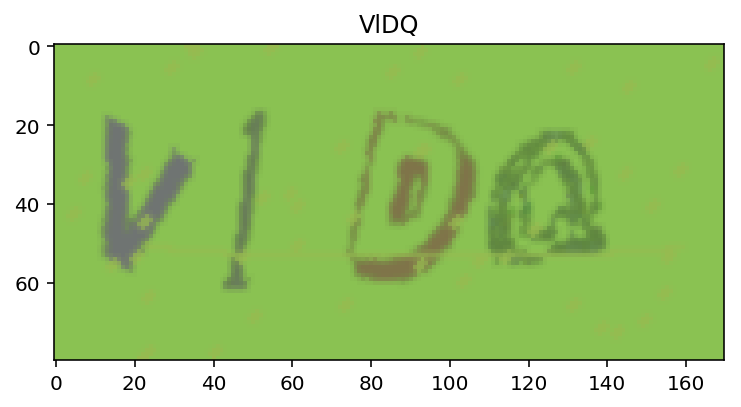

In [36]:
def decode(y):
    y = np.argmax(np.array(y), axis=2)[:,0]
    return ''.join([characters[x] for x in y])

X, y = next(gen(1))
#X, y = next(file_iter(1, 'data/train'))
plt.imshow(X[0])
plt.title(decode(y))

In [38]:

#x_train, y_train = list(next(gen(500000)))
#x_test, y_test = list(next(gen(100000)))
#print('done')
#gen_pickle(1,10,'pickle/train')
#x_train, y_train = list(next(pickle_iter(1,10, 'pickle/train')))
#gen_file(1000000, 'data/train')
#pool = Pool(4)
#arg_lists = [(i,1000, 'data/train') for i in range(100)]
#pool.starmap(gen_one_pickle, arg_lists)

#pool = Pool(15)
#arg_lists = [(i,1000, 'pickle/train') for i in range(2000)]
#pool.starmap(gen_one_pickle, arg_lists)

pool = Pool(15)
arg_lists = [(i,1000, 'pickle/test') for i in range(400)]
pool.starmap(gen_one_pickle, arg_lists)

#gen_file(200000, 'data/test')
#x_train, y_train = list(next(file_iter(100, 'data/train')))
#x_train2, y_train2 = gen_full(1000000)
#x_test2, y_test2 = gen_full(200000)


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

# 定义网络结构

In [18]:
from keras.models import *
from keras.layers import *

input_tensor = Input((height, width, 3))
x = input_tensor
for i in range(4):
    x = Convolution2D(32*2**i, 3, 3, activation='relu')(x)
    x = Convolution2D(32*2**i, 3, 3, activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(4)]
model = Model(input=input_tensor, output=x)

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

/home/ccloud/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  import sys
/home/ccloud/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  
/home/ccloud/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  import sys
/home/ccloud/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  
/home/ccloud/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
  import sys
/home/ccloud/anacon

# 网络结构可视化

In [ ]:
#from keras.utils.visualize_util import plot
#from IPython.display import Image

#plot(model, to_file="model.png", show_shapes=True)
#Image('model.png')

# 训练模型

In [19]:
class PickleSequenceData(Sequence):
    def __init__(self, path, batch_size):
        # path：存放所有图片的文件夹
        self.path = path
        self.batch_size = batch_size

    def __len__(self):
        # 让代码知道这个序列的长度
        return self.batch_size

    def __getitem__(self, i):
        # 迭代器部分
        #print("pickle load dir %s, seq %d" % (self.path, i) )
        with gzip.open("%s/p-%d" % (self.path, i), 'rb' ) as f:
            X, y = pickle.load(f)
        return X, y

In [ ]:
#model.fit(x=x_train, y=y_train, epochs=10, batch_size=30,  
#                    validation_data=[x_test,y_test])

In [21]:
#model.fit_generator(file_iter(20,'data/train'), samples_per_epoch=50000, nb_epoch=5, 
#                    nb_worker=3, pickle_safe=True, 
#                    validation_data=file_iter(20,'data/test'), nb_val_samples=10000)
#model.fit_generator(pickle_iter(10, 1000,'pickle/train'), 
#                    validation_data=pickle_iter(2, 1000,'pickle/test'), steps_per_epoch=10, 
#                    epochs=3, validation_steps=2, workers=3, use_multiprocessing=True)

train_seq = PickleSequenceData('pickle/train', 2)
test_seq = PickleSequenceData('pickle/test', 1)


model.fit_generator(train_seq, 
                    validation_data=test_seq, steps_per_epoch=2, 
                    epochs=10, validation_steps=1, workers=2, use_multiprocessing=True)

#model.fit_generator(gen(20), 
 #                   validation_data=gen(20), steps_per_epoch=50000, 
 #                   epochs=5, validation_steps=10000, workers=3, use_multiprocessing=True)

Epoch 1/10
2/2 [==============================] - 60s 30s/step - loss: 16.5308 - c1_loss: 4.1319 - c2_loss: 4.1338 - c3_loss: 4.1353 - c4_loss: 4.1298 - c1_acc: 0.0155 - c2_acc: 0.0135 - c3_acc: 0.0150 - c4_acc: 0.0150 - val_loss: 16.5085 - val_c1_loss: 4.1291 - val_c2_loss: 4.1280 - val_c3_loss: 4.1261 - val_c4_loss: 4.1252 - val_c1_acc: 0.0200 - val_c2_acc: 0.0170 - val_c3_acc: 0.0270 - val_c4_acc: 0.0170
Epoch 2/10
2/2 [==============================] - 59s 29s/step - loss: 16.5112 - c1_loss: 4.1278 - c2_loss: 4.1279 - c3_loss: 4.1259 - c4_loss: 4.1296 - c1_acc: 0.0230 - c2_acc: 0.0130 - c3_acc: 0.0155 - c4_acc: 0.0145 - val_loss: 16.5131 - val_c1_loss: 4.1284 - val_c2_loss: 4.1315 - val_c3_loss: 4.1264 - val_c4_loss: 4.1268 - val_c1_acc: 0.0150 - val_c2_acc: 0.0130 - val_c3_acc: 0.0110 - val_c4_acc: 0.0170
Epoch 3/10
2/2 [==============================] - 59s 30s/step - loss: 16.5054 - c1_loss: 4.1270 - c2_loss: 4.1247 - c3_loss: 4.1268 - c4_loss: 4.1268 - c1_acc: 0.0235 - c2_acc: 

# 测试模型

In [ ]:
#model = load_model('cnn.h5')
#model.save('cnn_200w_epoch10.h5')
X, y = next(gen(1))
y_pred = model.predict(X)
plt.title('real: %s\npred:%s'%(decode(y), decode(y_pred)))
plt.imshow(X[0], cmap='gray')
plt.axis('off')

# 计算模型总体准确率

In [ ]:
from tqdm import tqdm
def evaluate(model, batch_num=2000):
    batch_acc = 0
    generator = gen(1)
    for i in tqdm(range(batch_num)):
        X, y = next(generator)
        y_pred = model.predict(X)
        y_pred = np.argmax(y_pred, axis=2).T
        y_true = np.argmax(y, axis=2).T
        if np.array_equal(y_true, y_pred):
            batch_acc += 1
    return batch_acc / batch_num


evaluate(model)

# 保存模型

In [ ]:
model.save('cnn_200w_epoch10.h5')